#### Loading data

In [1]:
suppressPackageStartupMessages(library(TreeSummarizedExperiment))
suppressPackageStartupMessages(library(ggpubr))
quantDir <- "/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=2:6/post_type=gibbs_nrep=100_tf=100/salmon_quants"
saveDir <- "../../environment/brain_sim_normal"
samples <- as.vector(outer(c(1:6), c(1,2), function(x,y) paste(x,y,sep="_")))
                           
files <- file.path(quantDir, samples, "quant.sf")
coldata <- data.frame(files = files, names = samples, condition = as.factor(rep(c(1,2),each=6)))
clustFile <- "/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=2:6/post_type=gibbs_nrep=100_tf=100/terminus/no_threshold0/cluster_nwk.txt"
tseCons <- beaveR::buildTSE(treeTermFile = clustFile, coldata = coldata)
treeCons <- rowTree(tseCons)
l <- length(treeCons$tip)
termFile <- "/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=2:6/post_type=gibbs_nrep=100_tf=100/terminus/old/1_1/clusters.txt"

reading tree

importing quantifications

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


found matching transcriptome:
[ GENCODE - Homo sapiens - release 26 ]

loading existing TxDb created: 2023-03-02 17:08:07

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

loading existing transcript ranges created: 2023-03-02 21:45:10

Missing txps 3817

Aggregation Started

Aggregation Ended



#### Loading True counts

In [2]:
load("/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=2:6/sim_expr.rda")
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(source("../../tree_helper.R"))
saveDir <- "../../environment/brain_sim_normal"
suppressPackageStartupMessages(library(TreeSummarizedExperiment))

missingTxps <- setdiff(treeCons$tip.label, rownames(sim.counts.mat))
dts <- Reduce(union, c(names(iso.dge)[iso.dge], names(iso.dte)[iso.dte], names(iso.dte.only)[iso.dte.only], 
                       names(iso.dtu)[iso.dtu]))
dts <- intersect(dts, rownames(sim.counts.mat))
sim.counts.mat <- rbind(sim.counts.mat, matrix(0, nrow = length(missingTxps), ncol = ncol(sim.counts.mat),
                                               dimnames = list(missingTxps, colnames(sim.counts.mat))))
sim.counts.mat <- sim.counts.mat[treeCons$tip.label,]
dts <- intersect(dts, rownames(sim.counts.mat))

l <- length(treeCons$tip)
innNodes <- l+1:treeCons$Nnode
aggCountsNodes <- computeAggNodes(treeCons, c(1:length(treeCons$tip),innNodes), sim.counts.mat)
logFCNodes <- ifelse(rowSums(aggCountsNodes)==0, 0, log2(aggCountsNodes[,2]+1)-log2(aggCountsNodes[,1]+1))
names(logFCNodes)[(l+1):length(logFCNodes)] <- paste("Node", names(logFCNodes)[(l+1):length(logFCNodes)], sep="")
rootFC <- abs(logFCNodes[l+1])

#### Loading true counts

In [3]:
load(file.path(saveDir, "trenDiResPar.RData"))
load(file.path(saveDir, "trenDiRes.RData"))

In [4]:
detNodes <- lapply(trenDiResPar, function(nL) {
    ll <- lapply(nL, function(x) x[["candNodes"]])
    ll             
})
negNodes <- lapply(detNodes, function(nL) { 
    ll <- lapply(nL, function(x) setdiff(seq(length(treeCons$tip.label)), unlist(phangorn::Descendants(treeCons, x))))
    ll
})

In [5]:
names(detNodes)[1:6] <- gsub("minP", "minProp", names(detNodes)[1:6])
names(negNodes)[1:6] <- gsub("minP", "minProp", names(negNodes)[1:6])

In [8]:
df <- data.frame(Method=character(), Metric=character(), FDR_0.01 = numeric(), FDR_0.05 = numeric(), FDR_0.10 = numeric())
for(n in names(detNodes)) {
    stats <-  sapply(seq_along(detNodes[[n]]), function(i) computeMetOut(detNodes[[n]][[i]], logFCNodes, tree = treeCons, negNodes = negNodes[[n]][[i]], lfcThresh = rootFC))
    for(i in seq(ncol(stats)))
        stats[,i] <- round(unlist(stats[,i]),3)
#     print(stats)
    colnames(stats) <- colnames(df)[c(3:5)]
    stats <- cbind(Method=rep(n,2), Metric = c("FDR", "TPR"), stats)
    df <- rbind(df, stats)   
}

In [9]:
for(i in seq(ncol(df))) {
    if (i <=2) {
        df[,i] <- as.character(unlist(df[,i]))
    }
    else {
        df[,i] <- as.numeric(unlist(df[,i]))
    }
}

#### Varying the minimum proportion of samples for the sign

In [10]:
dfA <- df %>% filter(str_detect(Method, "minProp")) %>%
tidyr::pivot_wider(names_from = Metric, values_from = c(3:5))
dfA <- dfA[,c(1,seq(2,7,2),seq(3,7,2))]
dfA <- dfA %>% 
    mutate(keep_0.01=ifelse(FDR_0.01_FDR <= 0.01, T, F)) %>%
    mutate(keep_0.05=ifelse(FDR_0.05_FDR <= 0.05, T, F)) %>%
    mutate(keep_0.10=ifelse(FDR_0.10_FDR <= 0.10, T, F))
dfA

Method,FDR_0.01_FDR,FDR_0.05_FDR,FDR_0.10_FDR,FDR_0.01_TPR,FDR_0.05_TPR,FDR_0.10_TPR,keep_0.01,keep_0.05,keep_0.10
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>
minProp=0.6,0.01,0.051,0.090,0.655,0.771,0.816,TRUE,FALSE,TRUE
minProp=0.65,0.01,0.051,0.091,0.655,0.771,0.817,TRUE,FALSE,TRUE
minProp=0.75,0.01,0.052,0.091,0.656,0.771,0.817,TRUE,FALSE,TRUE
minProp=0.8,0.01,0.052,0.091,0.656,0.771,0.817,TRUE,FALSE,TRUE
minProp=0.85,0.01,0.052,0.091,0.656,0.772,0.817,TRUE,FALSE,TRUE
minProp=0.9,0.01,0.052,0.091,0.656,0.772,0.817,TRUE,FALSE,TRUE


In [17]:
df1 <- dfA %>% 
  pivot_longer(starts_with("FDR"),
  names_to = c("fdr", ".value"),
  names_pattern = "(.+)_(.+)"
  ) %>% select(fdr, FDR, TPR, Method)
df2 <- dfA %>% pivot_longer(starts_with("keep"), 
                    names_to = c(".value", "fdr"),
                    names_sep="_") %>% select(keep)
dfC <- bind_cols(df1, df2)
dfC$FDR <- unlist(dfC$FDR)
dfC$TPR <- unlist(dfC$TPR)
dfC$Method <- unlist(dfC$Method)
dfC <- dfC %>% 
    mutate(minP=gsub("minProp=", "", Method))
dfC

fdr,FDR,TPR,Method,keep,minP
<chr>,<dbl>,<dbl>,<chr>,<lgl>,<chr>
FDR_0.01,0.010,0.655,minProp=0.6,TRUE,0.6
FDR_0.05,0.051,0.771,minProp=0.6,FALSE,0.6
FDR_0.10,0.090,0.816,minProp=0.6,TRUE,0.6
FDR_0.01,0.010,0.655,minProp=0.65,TRUE,0.65
FDR_0.05,0.051,0.771,minProp=0.65,FALSE,0.65
FDR_0.10,0.091,0.817,minProp=0.65,TRUE,0.65
FDR_0.01,0.010,0.656,minProp=0.75,TRUE,0.75
FDR_0.05,0.052,0.771,minProp=0.75,FALSE,0.75
FDR_0.10,0.091,0.817,minProp=0.75,TRUE,0.75


#### Varying the threshold for meaninfRV threshold

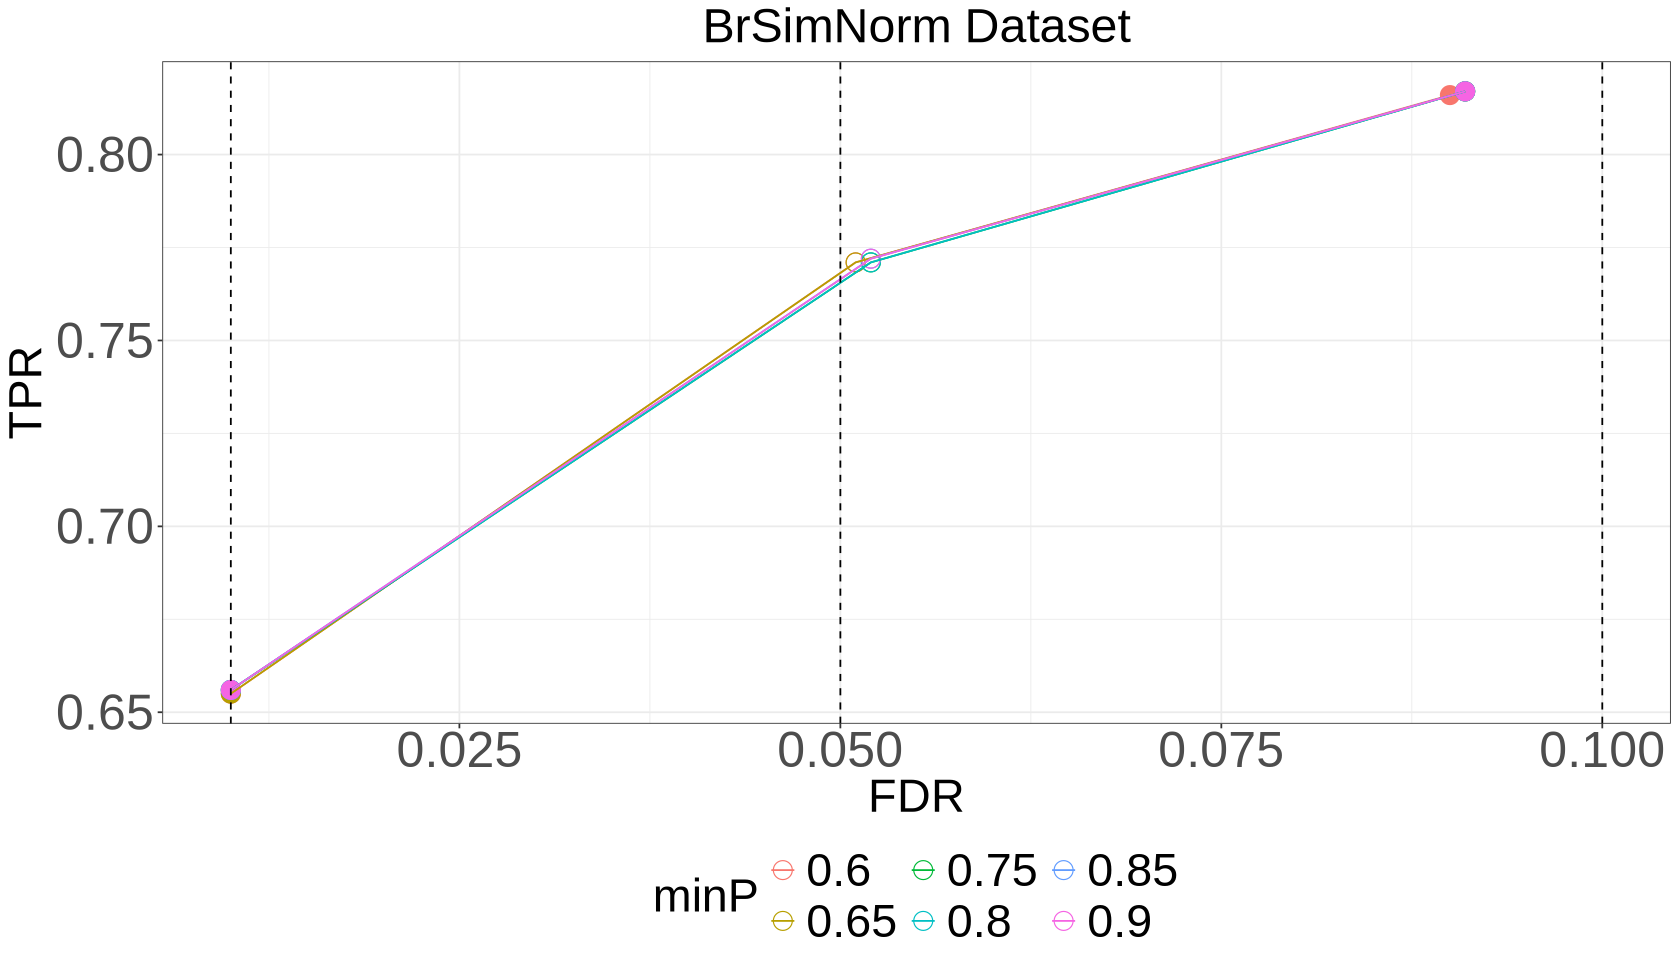

In [18]:
options(repr.plot.width=14, repr.plot.height=8)
size <- 28
pBrMinP <- ggplot(dfC, aes(x = FDR, y = TPR, 
                             color = minP                            
                             )) + 
                geom_point(size=5,shape=21, aes(fill = ifelse(keep, Method, NA))) + 
                scale_fill_discrete(na.value = "transparent") +
                geom_line() +
                theme_bw() +
                geom_vline(xintercept = c(0.01, 0.05, 0.1), linetype = "dashed") +
                ggtitle("BrSimNorm Dataset") +
                theme(axis.title = element_text(size = size),
                plot.title = element_text(size = size + 1, hjust=0.5),
                axis.text = element_text(size = size+2),
                legend.text = element_text(size = size),
                legend.title = element_text(size = size),
                legend.position = "bottom") +
                guides(fill = "none")
pBrMinP

In [19]:
dfA <- df %>% filter(str_detect(Method, "mirv")) %>%
tidyr::pivot_wider(names_from = Metric, values_from = c(3:5))
dfA <- dfA[,c(1,seq(2,7,2),seq(3,7,2))]
dfA <- dfA %>% 
    mutate(keep_0.01=ifelse(FDR_0.01_FDR <= 0.01, T, F)) %>%
    mutate(keep_0.05=ifelse(FDR_0.05_FDR <= 0.05, T, F)) %>%
    mutate(keep_0.10=ifelse(FDR_0.10_FDR <= 0.10, T, F))
dfA

Method,FDR_0.01_FDR,FDR_0.05_FDR,FDR_0.10_FDR,FDR_0.01_TPR,FDR_0.05_TPR,FDR_0.10_TPR,keep_0.01,keep_0.05,keep_0.10
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>
mirvThresh=0,0.015,0.074,0.132,0.701,0.808,0.844,FALSE,FALSE,FALSE
mirvThresh=0.05,0.014,0.069,0.122,0.702,0.808,0.845,FALSE,FALSE,FALSE
mirvThresh=0.1,0.012,0.058,0.103,0.689,0.800,0.840,FALSE,FALSE,FALSE
mirvThresh=0.15,0.011,0.055,0.097,0.678,0.789,0.832,FALSE,FALSE,TRUE
mirvThresh=0.2,0.011,0.054,0.095,0.670,0.783,0.827,FALSE,FALSE,TRUE
mirvThresh=0.25,0.010,0.053,0.094,0.665,0.778,0.822,TRUE,FALSE,TRUE
mirvThresh=0.3,0.010,0.053,0.093,0.661,0.775,0.820,TRUE,FALSE,TRUE
mirvThresh=0.35,0.010,0.052,0.092,0.658,0.773,0.818,TRUE,FALSE,TRUE
mirvThresh=0.5,0.010,0.051,0.090,0.651,0.767,0.814,TRUE,FALSE,TRUE


In [21]:
df1 <- dfA %>% 
  pivot_longer(starts_with("FDR"),
  names_to = c("fdr", ".value"),
  names_pattern = "(.+)_(.+)"
  ) %>% select(fdr, FDR, TPR, Method)
df2 <- dfA %>% pivot_longer(starts_with("keep"), 
                    names_to = c(".value", "fdr"),
                    names_sep="_") %>% select(keep)
dfC <- bind_cols(df1, df2)
dfC$FDR <- unlist(dfC$FDR)
dfC$TPR <- unlist(dfC$TPR)
dfC$Method <- unlist(dfC$Method)
dfC <- dfC %>% mutate(FDR=round(FDR,3), TPR=round(TPR, 3))
dfC <- dfC %>% filter(Method %in% paste("mirvThresh", seq(0,1,0.1), sep="="))
dfC <- dfC %>% 
    mutate(mIRV=gsub("mirvThresh=", "", Method))
dfC

fdr,FDR,TPR,Method,keep,mIRV
<chr>,<dbl>,<dbl>,<chr>,<lgl>,<chr>
FDR_0.01,0.015,0.701,mirvThresh=0,FALSE,0
FDR_0.05,0.074,0.808,mirvThresh=0,FALSE,0
FDR_0.10,0.132,0.844,mirvThresh=0,FALSE,0
FDR_0.01,0.012,0.689,mirvThresh=0.1,FALSE,0.1
FDR_0.05,0.058,0.800,mirvThresh=0.1,FALSE,0.1
FDR_0.10,0.103,0.840,mirvThresh=0.1,FALSE,0.1
FDR_0.01,0.011,0.670,mirvThresh=0.2,FALSE,0.2
FDR_0.05,0.054,0.783,mirvThresh=0.2,FALSE,0.2
FDR_0.10,0.095,0.827,mirvThresh=0.2,TRUE,0.2


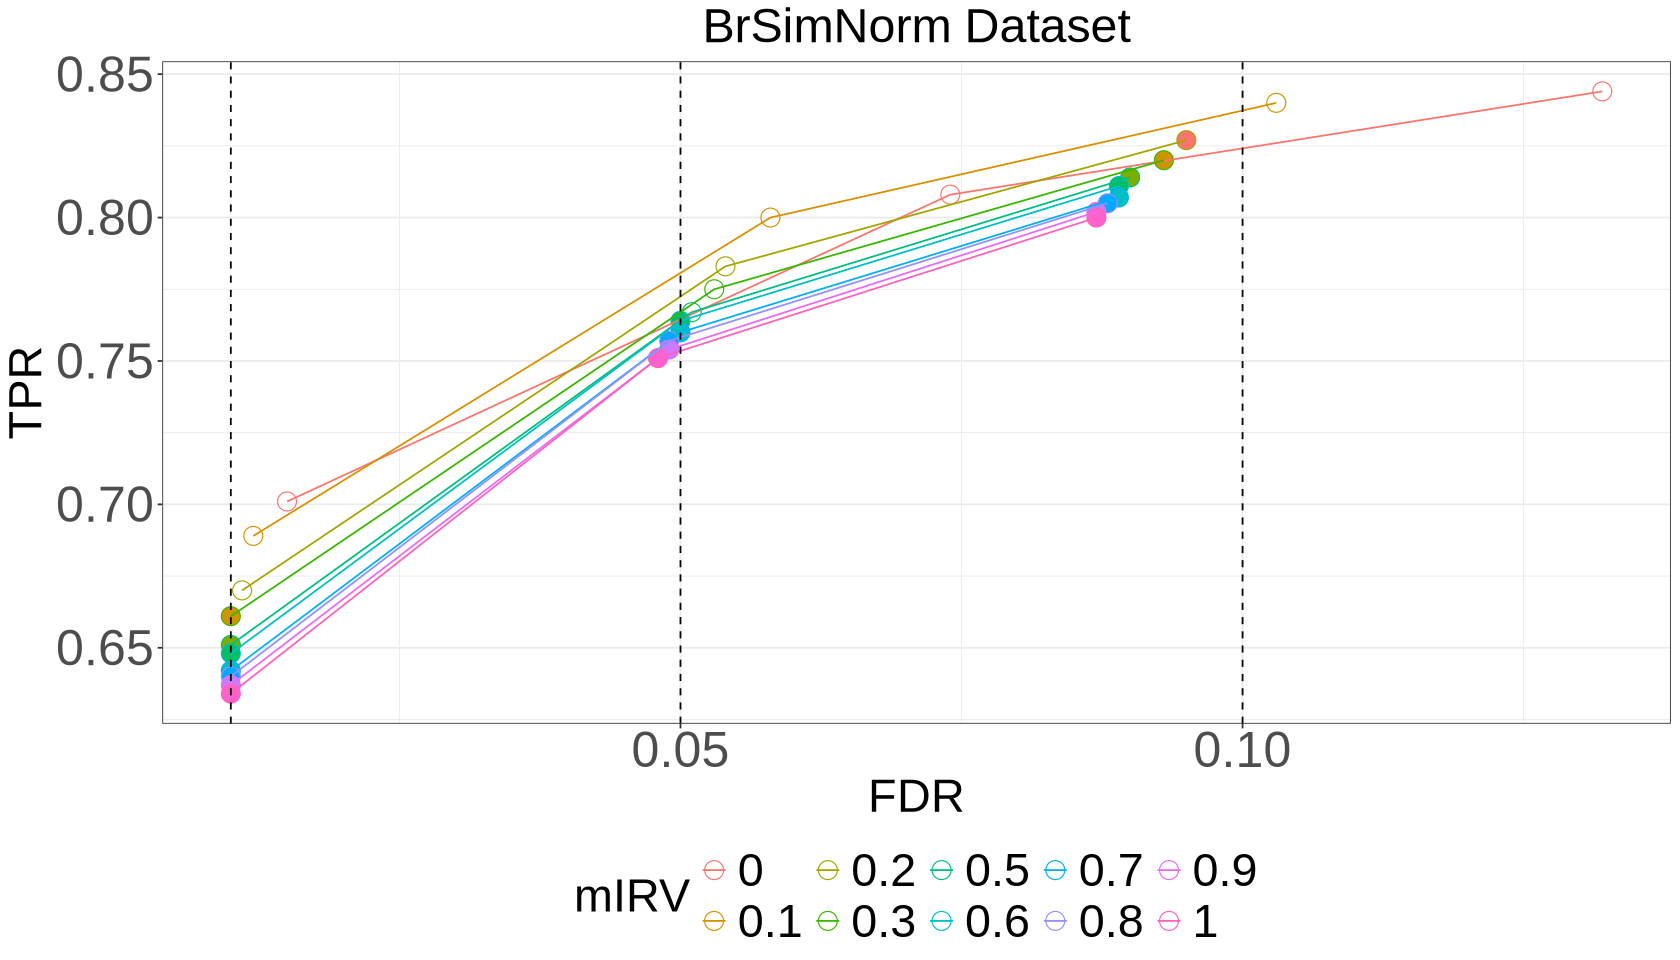

In [23]:
options(repr.plot.width=14, repr.plot.height=8)
size <- 28
pBrThresh <- ggplot(dfC, aes(x = FDR, y = TPR, 
                             color = mIRV                            
                             )) + 
                geom_point(size=5,shape=21, aes(fill = ifelse(keep, Method, NA))) + 
                scale_fill_discrete(na.value = "transparent") +
                geom_line() +
                theme_bw() +
                geom_vline(xintercept = c(0.01, 0.05, 0.1), linetype = "dashed") +
                ggtitle("BrSimNorm Dataset") +
                theme(axis.title = element_text(size = size),
                plot.title = element_text(size = size + 1, hjust=0.5),
                axis.text = element_text(size = size+2),
                legend.text = element_text(size = size),
                legend.title = element_text(size = size),
                legend.position = "bottom") +
                guides(fill = "none", color = guide_legend(nrow = 2))
pBrThresh

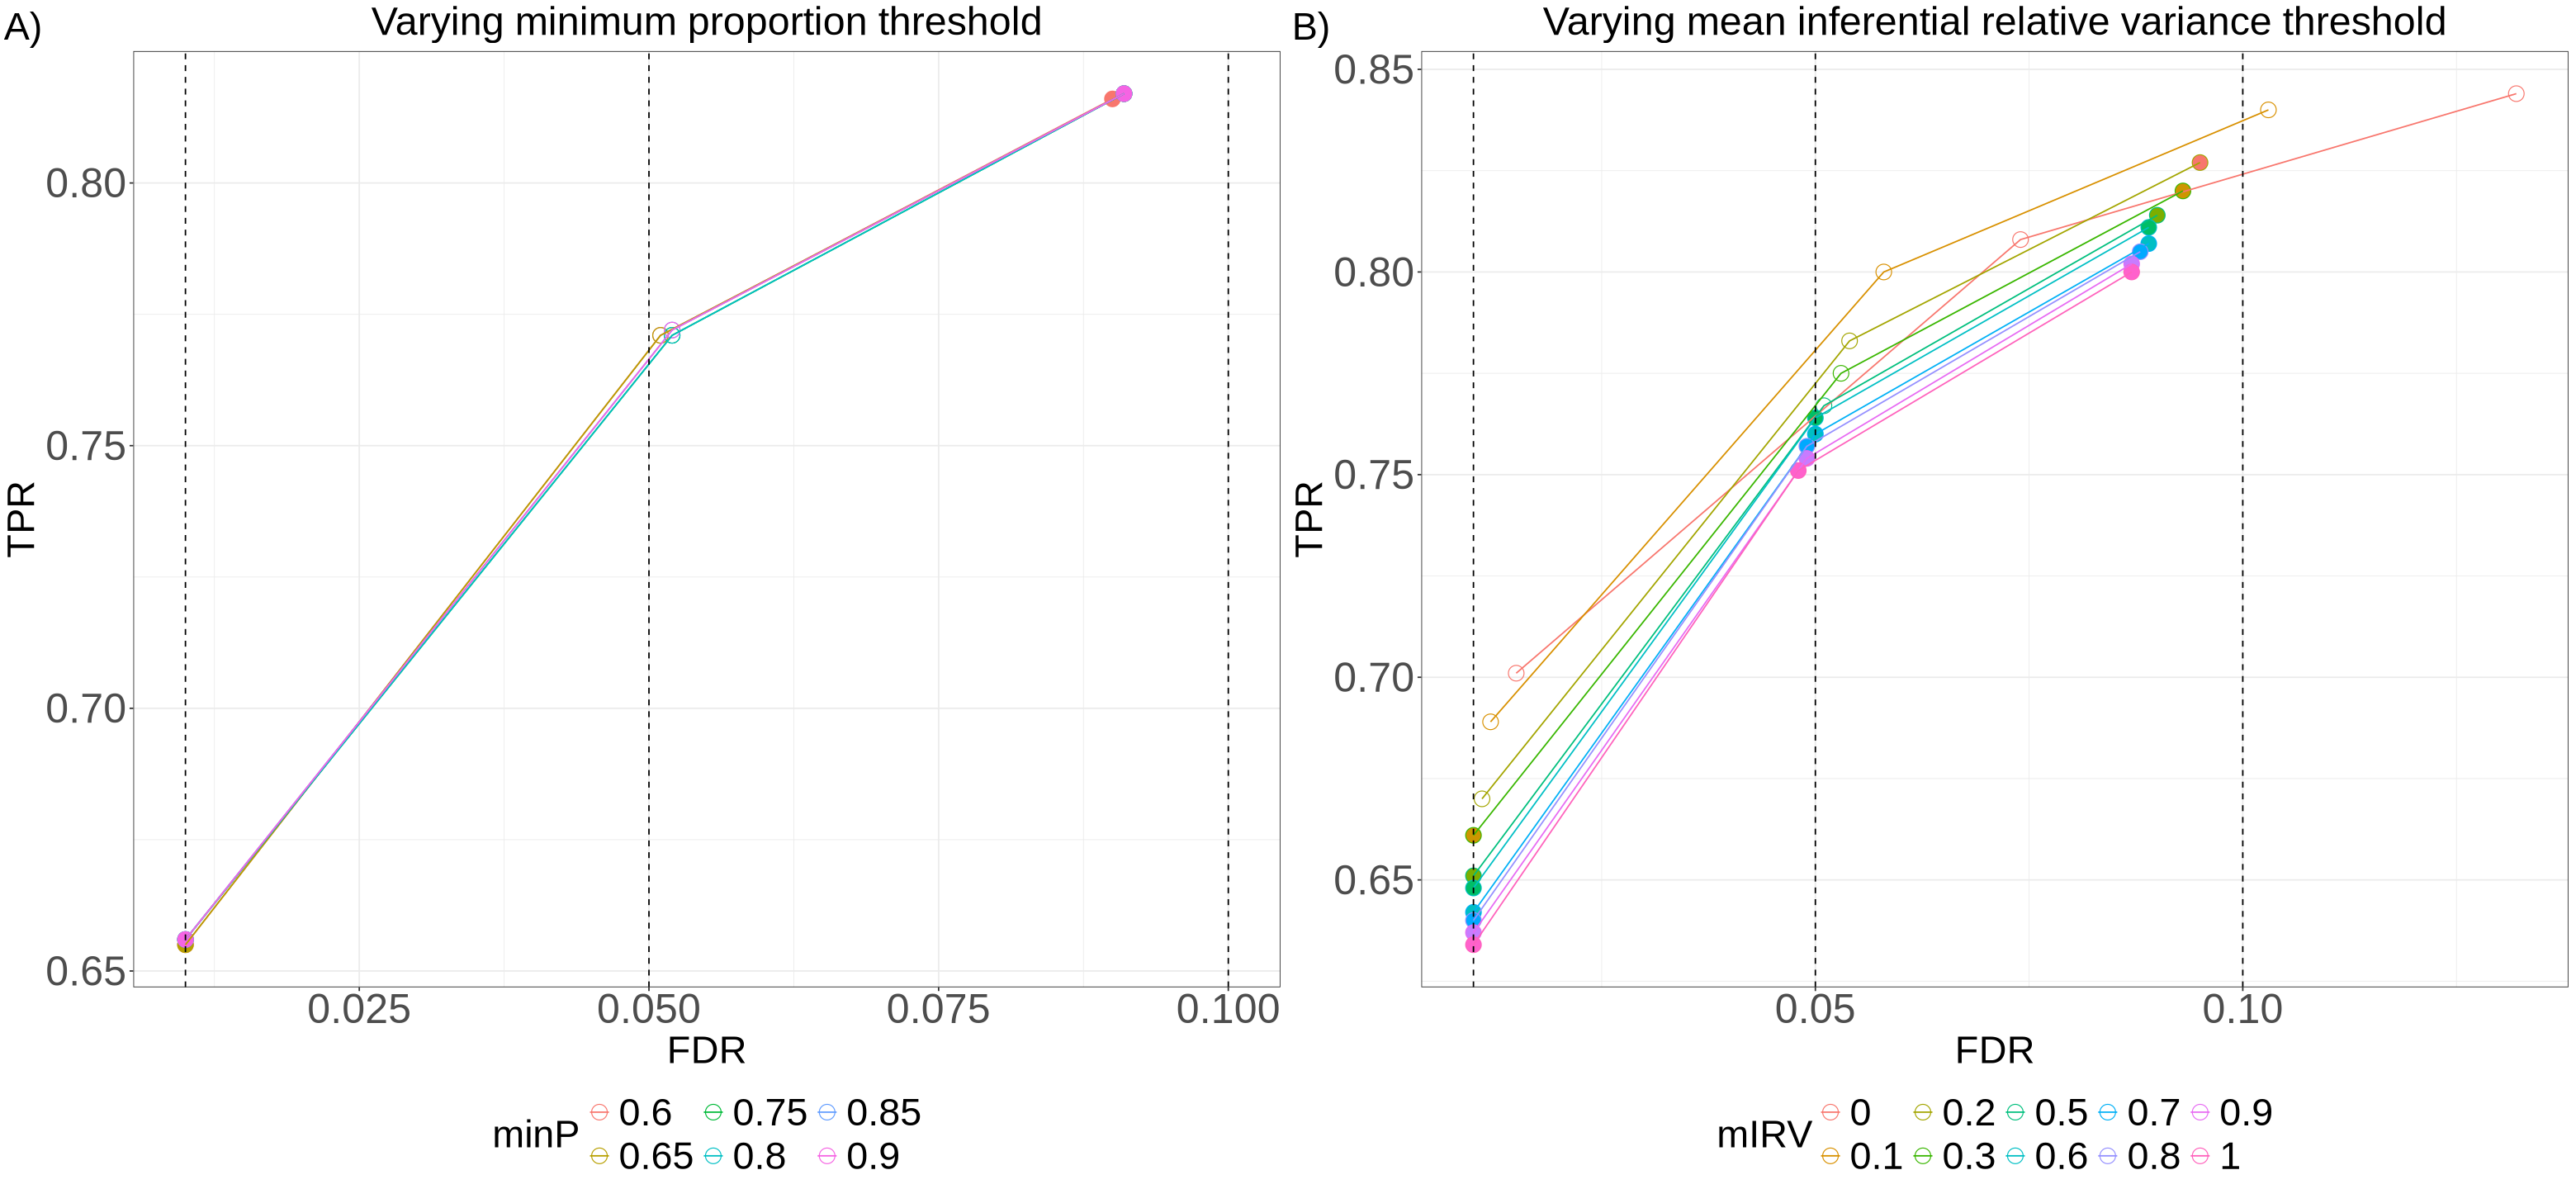

In [24]:
options(repr.plot.width=26, repr.plot.height=12)
ggarrange(pBrMinP + ggtitle("Varying minimum proportion threshold"),
              pBrThresh + ggtitle("Varying mean inferential relative variance threshold"),
              hjust=-0.1, labels = c("A)", "B)"),
              legend="bottom", font.label=list(size=size, face="plain")
    )

In [5]:
defaultNodes <- lapply(trenDiRes, function(x) x[["candNodes"]])
sapply(defaultNodes, length)
defaultTxps <- lapply(defaultNodes, function(x) unlist(phangorn::Descendants(treeCons, x)))
sapply(defaultTxps, length)

[1] 5072 6350 7105

[1] 7257 8685 9503

In [12]:
sapply(detNodes[1:6], function(x) {
    ll <- sapply(x, length)
})
sapply(detNodes[7:20], function(x) {
    ll <- sapply(x, length)
})
rowMeans(sapply(detNodes[1:6], function(x) {
    ll <- sapply(x, length)
}))
rowSds(sapply(detNodes[1:6], function(x) {
    ll <- sapply(x, length)
}))
rowMeans(sapply(detNodes[7:20], function(x) {
    ll <- sapply(x, length)
}))
rowSds(sapply(detNodes[7:20], function(x) {
    ll <- sapply(x, length)
}))

minP=0.6,minP=0.65,minP=0.75,minP=0.8,minP=0.85,minP=0.9
5078,5073,5072,5073,5073,5073
6354,6350,6350,6351,6351,6350
7108,7104,7105,7106,7108,7108


mirvThresh=0,mirvThresh=0.05,mirvThresh=0.1,mirvThresh=0.15,mirvThresh=0.2,mirvThresh=0.25,mirvThresh=0.3,mirvThresh=0.35,mirvThresh=0.5,mirvThresh=0.6,mirvThresh=0.7,mirvThresh=0.8,mirvThresh=0.9,mirvThresh=1
3604,3884,4533,4794,4883,4957,5002,5040,5117,5157,5179,5206,5219,5223
4452,4819,5669,5987,6084,6192,6244,6297,6393,6424,6452,6482,6495,6505
4961,5401,6361,6700,6824,6942,6993,7048,7158,7191,7228,7253,7269,7279


[1] 5073.667 6351.000 7106.500

[1] 2.160247 1.549193 1.760682

[1] 4842.714 6035.357 6757.714

[1] 506.5798 641.2644 720.8511

#### Intersection between nodes

In [13]:
sapply(defaultNodes, length)
sapply(detNodes[1:6], function(minP) {
    mapply(function(x,y) length(intersect(x,y)), minP, defaultNodes)
})
sapply(detNodes[7:20], function(mirv) {
    mapply(function(x,y) length(intersect(x,y)), mirv, defaultNodes)
})


[1] 5072 6350 7105

minP=0.6,minP=0.65,minP=0.75,minP=0.8,minP=0.85,minP=0.9
5019,5051,5063,5046,5025,5011
6283,6322,6335,6311,6284,6265
7022,7068,7088,7062,7029,7007


mirvThresh=0,mirvThresh=0.05,mirvThresh=0.1,mirvThresh=0.15,mirvThresh=0.2,mirvThresh=0.25,mirvThresh=0.3,mirvThresh=0.35,mirvThresh=0.5,mirvThresh=0.6,mirvThresh=0.7,mirvThresh=0.8,mirvThresh=0.9,mirvThresh=1
1827,2275,3427,4034,4324,4564,4755,4917,4900,4782,4674,4611,4557,4523
2449,3018,4454,5160,5474,5775,5973,6165,6170,6051,5937,5865,5809,5761
2820,3483,5083,5829,6184,6506,6706,6905,6921,6786,6669,6597,6539,6491


In [6]:
detNodesTxps <- lapply(detNodes, function(mi) {
  ll <- lapply(mi, function(nodes) unlist(phangorn::Descendants(treeCons, nodes)))  
}) 

In [19]:
sapply(defaultTxps, length)
sapply(detNodesTxps[1:6], function(minP) {
    mapply(function(x,y) length(intersect(x,y)), minP, defaultTxps)
})
sapply(detNodesTxps[7:20], function(mirv) {
    mapply(function(x,y) length(intersect(x,y)), mirv, defaultTxps)
})


[1] 7257 8685 9503

minP=0.6,minP=0.65,minP=0.75,minP=0.8,minP=0.85,minP=0.9
7167,7221,7257,7257,7257,7257
8568,8636,8685,8685,8685,8685
9350,9429,9503,9503,9503,9503


mirvThresh=0,mirvThresh=0.05,mirvThresh=0.1,mirvThresh=0.15,mirvThresh=0.2,mirvThresh=0.25,mirvThresh=0.3,mirvThresh=0.35,mirvThresh=0.5,mirvThresh=0.6,mirvThresh=0.7,mirvThresh=0.8,mirvThresh=0.9,mirvThresh=1
7257,7257,7257,7257,7257,7257,7257,7257,7043,6881,6705,6604,6489,6408
8685,8685,8685,8685,8685,8685,8685,8685,8441,8262,8095,7977,7862,7775
9503,9503,9503,9503,9503,9503,9503,9503,9262,9065,8893,8772,8653,8566


In [7]:
n1 <- detNodes[["minP=0.6"]][[1]]
n2 <- trenDiRes[[1]][["candNodes"]]

In [7]:
length(n1)
length(n2)

[1] 5078

[1] 5072

In [10]:
table(node.depth(treeCons, 2)[n1])
table(node.depth(treeCons, 2)[n2])


   1    2    3    4    5    6    7    8    9   10   11   12   13   14 
4048  547  251  118   57   26   10    8    5    3    1    2    1    1 


   1    2    3    4    5    6    7    8    9   10   11   12   13   14 
4013  554  256  125   62   28   12    9    4    4    1    2    1    1 

In [17]:
print(length(setdiff(defaultTxps[[1]], detNodesTxps[[1]][[1]])))
print(length(setdiff(detNodesTxps[[1]][[1]], defaultTxps[[1]])))
print(head(setdiff(defaultTxps[[1]], detNodesTxps[[1]][[1]])))

[1] 90
[1] 0
[1]  4928  9100  9271  9946 14675 16140


In [8]:
yAll <- beaveR::computeSizeFactors(tseCons)
yAll <- beaveR::scInfReps(yAll)
yAll <- fishpond::labelKeep(yAll)
metadata(yAll)[["infRepsScaled"]] <- TRUE
yTxps <- fishpond::swish(yAll[1:l,], x = "condition")

Setting inf rep depth to mean depth



Progress:   1 on 100Progress:   2 on 100Progress:   3 on 100Progress:   4 on 100Progress:   5 on 100Progress:   6 on 100Progress:   7 on 100Progress:   8 on 100Progress:   9 on 100Progress:  10 on 100Progress:  11 on 100Progress:  12 on 100Progress:  13 on 100Progress:  14 on 100Progress:  15 on 100Progress:  16 on 100Progress:  17 on 100Progress:  18 on 100Progress:  19 on 100Progress:  20 on 100Progress:  21 on 100Progress:  22 on 100Progress:  23 on 100Progress:  24 on 100Progress:  25 on 100Progress:  26 on 100Progress:  27 on 100Progress:  28 on 100Progress:  29 on 100Progress:  30 on 100Progress:  31 on 100Progress:  32 on 100Progress:  33 on 100Progress:  34 on 100Progress:  35 on 100Progress:  36 on 100Progress:  37 on 100Progress:  38 on 100Progress:  39 on 100Progress:  40 on 100Progress:  41 on 100Progress:  42 on 100Progress:  43 on 100Progress:  44 on 100Progress:  45 on 100Progress:  46 on 100Progress:  47 on 100Progress:  48 on 100Progress:  49 on 100Progress:  50 on 100

In [9]:
signs <- trenDi:::computeSign(y = yAll, x = "condition", minP = 0.6)
signs2 <- trenDi:::computeSign(y = yAll, x = "condition", minP = 0.7)

In [14]:
signs[head(setdiff(defaultTxps[[1]], detNodesTxps[[1]][[1]]))]
signs2[head(setdiff(defaultTxps[[1]], detNodesTxps[[1]][[1]]))]

[1]  1  1 -1  1  1  1

[1] 0 0 0 0 0 0

In [28]:
sapply(Ancestors(treeCons, head(setdiff(defaultTxps[[1]], detNodesTxps[[1]][[1]]))), function(x) x[1]) %in% defaultNodes[[1]]
sapply(Ancestors(treeCons, head(setdiff(defaultTxps[[1]], detNodesTxps[[1]][[1]]))), function(x) x[1])

[1]  TRUE  TRUE  TRUE  TRUE  TRUE FALSE

[1] 139122 142728 142878 143451 147535 148829

In [12]:
signs[Descendants(treeCons, 142728)[[1]]]
signs2[Descendants(treeCons,142728)[[1]]]
signs[142728]
signs2[142728]

# mcols(yTxps)[head(setdiff(defaultTxps[[1]], detNodesTxps[[1]][[1]])),]

[1] -1  1

[1] -1  0

[1] -1

[1] -1

The reason we have lesser number of nodes with lower threshold of sign change is because more lower level nodes get assigned a sign change and since the proceudre is top down, where all the descendants node should have the same or uncertain sign change, the nodes that could have been assigned an uncertain sign change can get assigned an opposing sign change, making us reject the inner node and going down. Going down, it might be the case that the signal is not strong or inferential uncertainty is high.